In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#  assign susceptibility based on age
def assign_susceptibility(ages):
    susceptibility = np.zeros_like(ages, dtype=float)
    for idx, age in enumerate(ages):
        if age < 30:
            susceptibility[idx] = 0.6 
        elif 30 <= age < 50:
            susceptibility[idx] = 0.3
        else:
            susceptibility[idx] = 0.1
    return susceptibility

In [3]:
# assign agents age groups 
def assign_age_group(age):
    if 18 <= age <= 35:
        return '18-35'
    elif 36 <= age <= 60:
        return '36-60'
    elif 61 <= age <= 70:
        return '61-70'
    else:
        return 'Unknown'

In [4]:
# calculate similarity factor based on opinion difference
def calculate_similarity_factor(i, j):
    diff_op = abs(i - j)
    similarity_factor = 1 - (diff_op / 2)  # normalise difference to [0,1]
    return similarity_factor

In [5]:
# function to handle diffusion, opinion changes, and media influence
def diffuse_and_opinion_change_with_media(
    x, y, opinions, d, beta, alpha, L, susceptibility, ages, media_sources, age_group_labels
):
    N = len(x)
    
    # agents move randomly with probability d
    diffuse = np.random.rand(N)  # random probabilities for diffusion
    move = np.random.randint(4, size=N)  # random direction: 0=left, 1=down, 2=right, 3=up
    for i in range(N):
        if diffuse[i] < d:  # ff agent diffuses
            if move[i] == 0:
                x[i] -= 1
            elif move[i] == 1:
                y[i] -= 1
            elif move[i] == 2:
                x[i] += 1
            else:
                y[i] += 1

    # periodic boundary conditions
    x = x % L
    y = y % L

    # agents in the same cell may influence each others opinions
    for i in range(N):
        same_cell_indices = np.where((x == x[i]) & (y == y[i]))[0]
        for j in same_cell_indices:
            if i == j:
                continue  # skip self-interaction
            if opinions[i] != opinions[j]:
                # calculate similarity factor
                similarity_factor = calculate_similarity_factor(opinions[i], opinions[j])

                # determine if agents are in the same age group
                same_age_group = age_group_labels[i] == age_group_labels[j]
                age_group_factor = 1.5 if same_age_group else 1.0  # higher influence if same age group

                # calculate final influence probability
                influence_prob = beta * age_group_factor * similarity_factor * susceptibility[i]

                # probability does not exceed 1
                influence_prob = min(influence_prob, 1.0)

                if np.random.rand() < influence_prob:
                    # agent i adopts agent js opinion with convergance rate
                    opinions[i] += gamma * (opinions[j] - opinions[i])

    # each media source influences its target age group
    for media in media_sources:
        target_min_age, target_max_age = media['target_age_range']
        media_opinion = media['media_opinion']
        influence_prob = media['influence_probability']
        
        # find agents within the target age range
        target_agents = np.where((ages >= target_min_age) & (ages <= target_max_age))[0]
        
        if len(target_agents) == 0:
            continue  # skip if no agents in the target range
        
        # agents influenced by the media
        influenced = target_agents[np.random.rand(len(target_agents)) < influence_prob]
        
        # Update opinions of influenced agents
        opinions[influenced] += delta * (media_opinion - opinions[influenced])

    # agents may switch back with probability alpha
    # chance for agents to change their opinion spontaneously
    change_opinion = np.random.rand(N) < alpha
    opinions[change_opinion] *= -1  # flip opinion

    return x, y, opinions


Run 1 started.

Run 2 started.

Run 3 started.

Run 4 started.

Run 5 started.


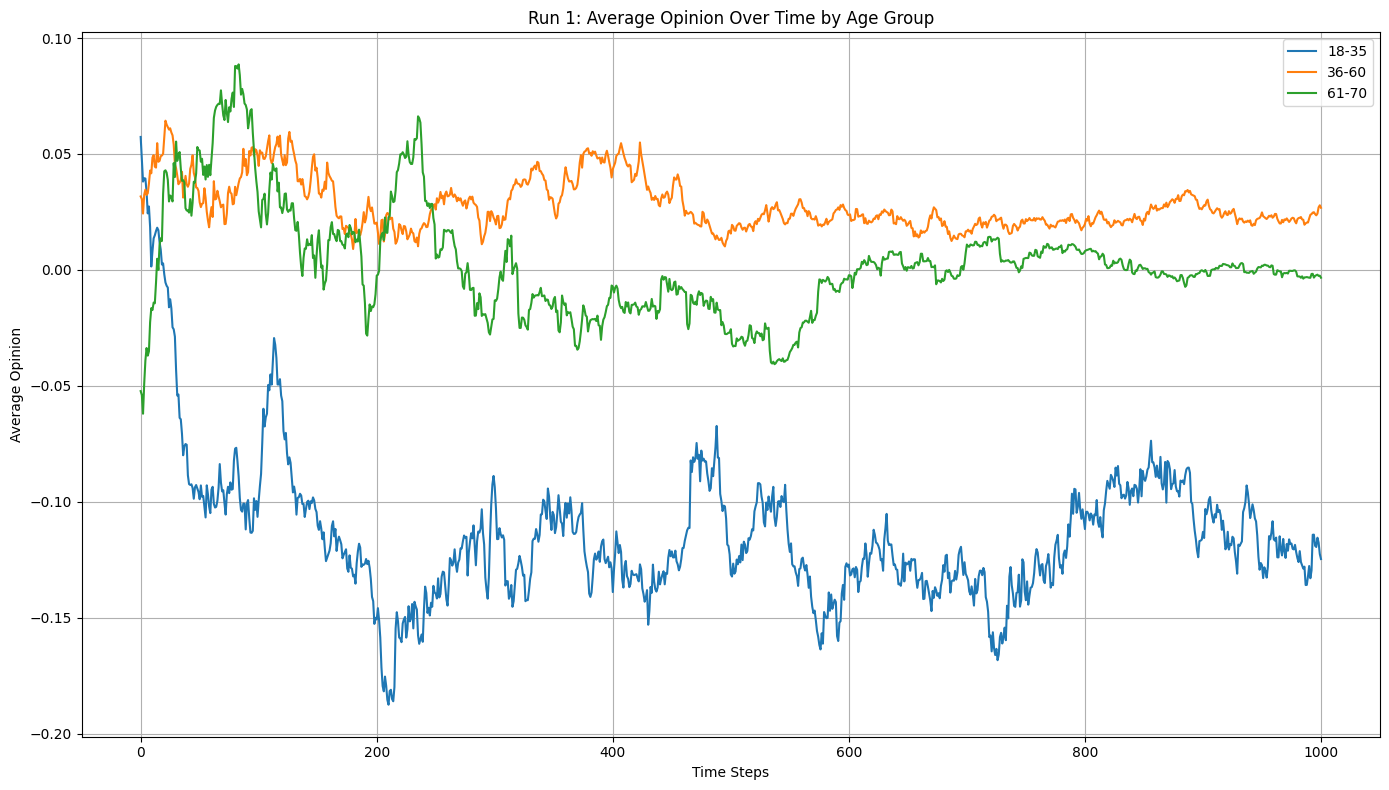

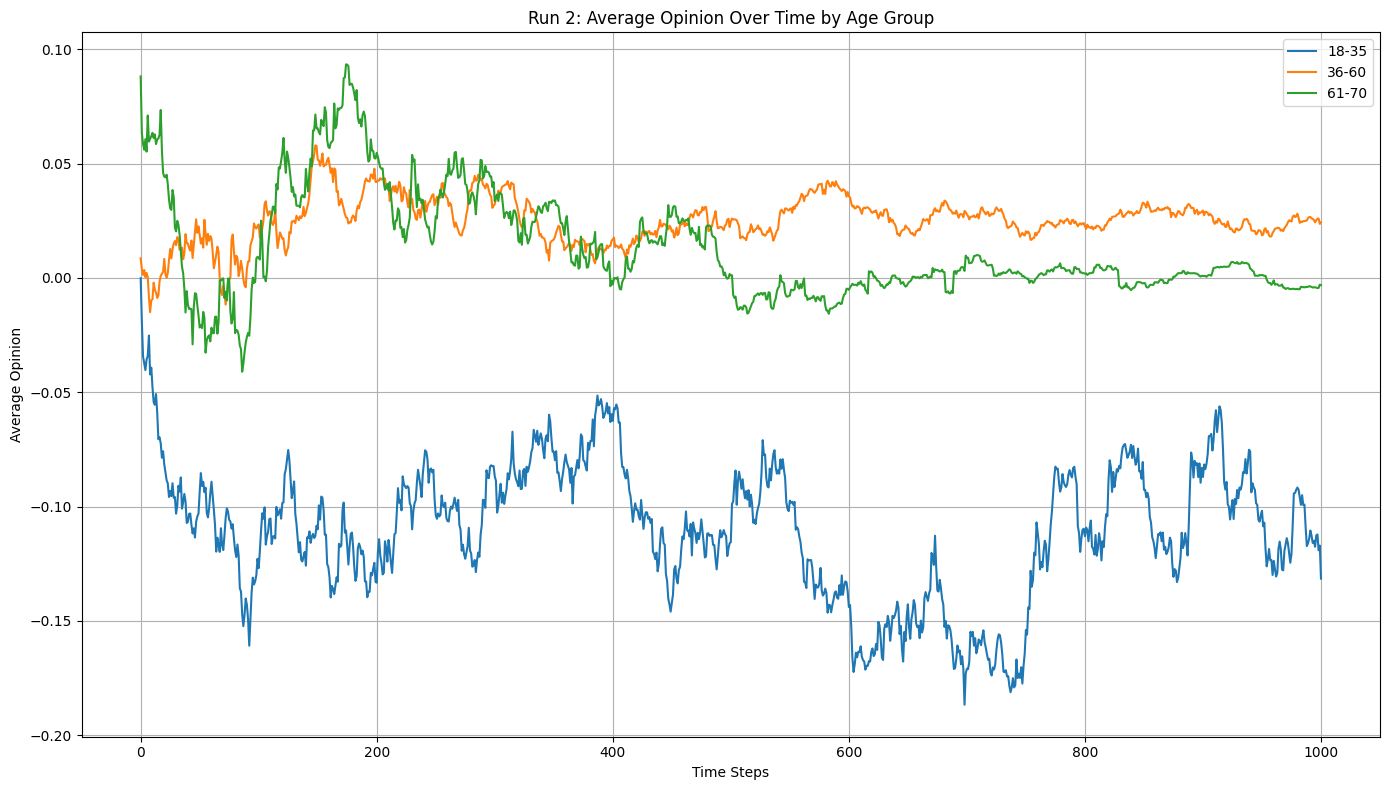

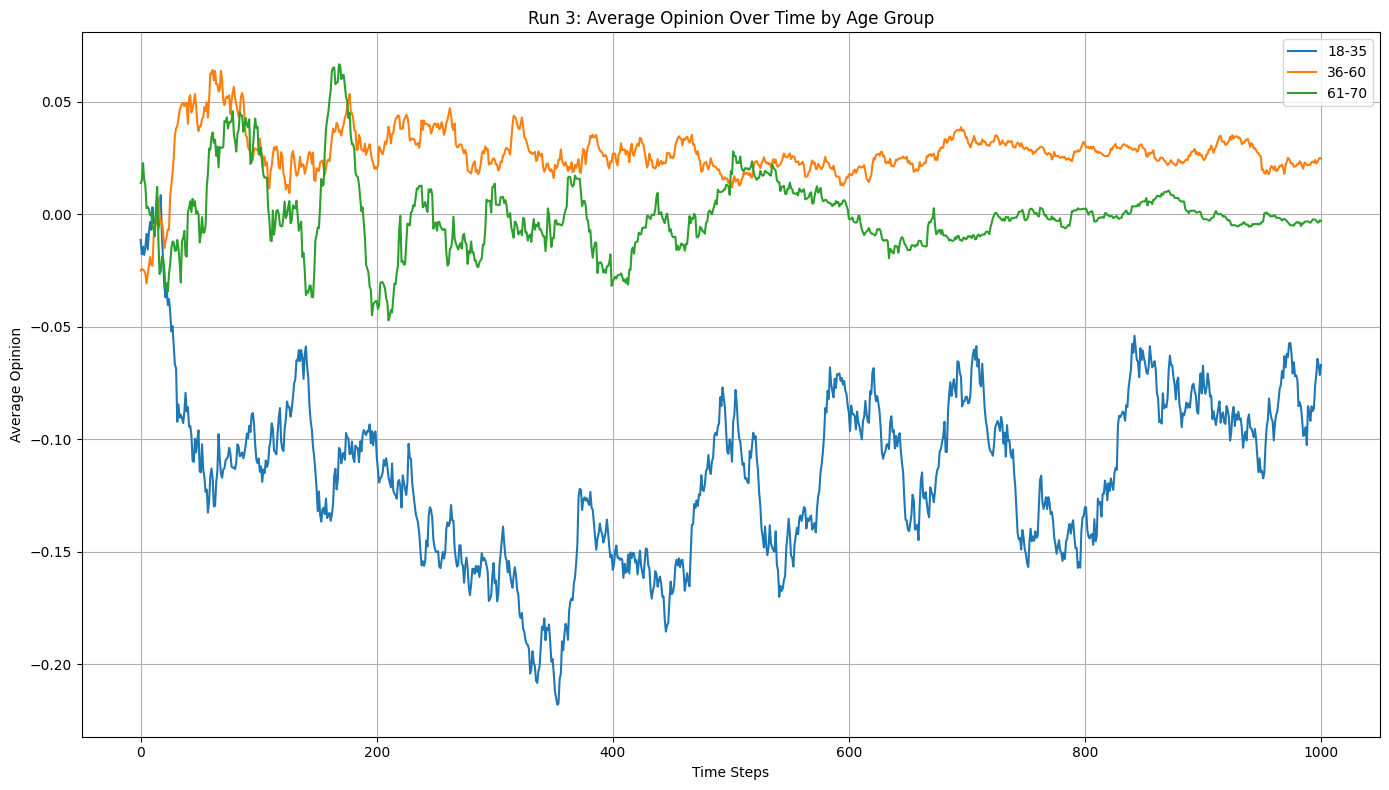

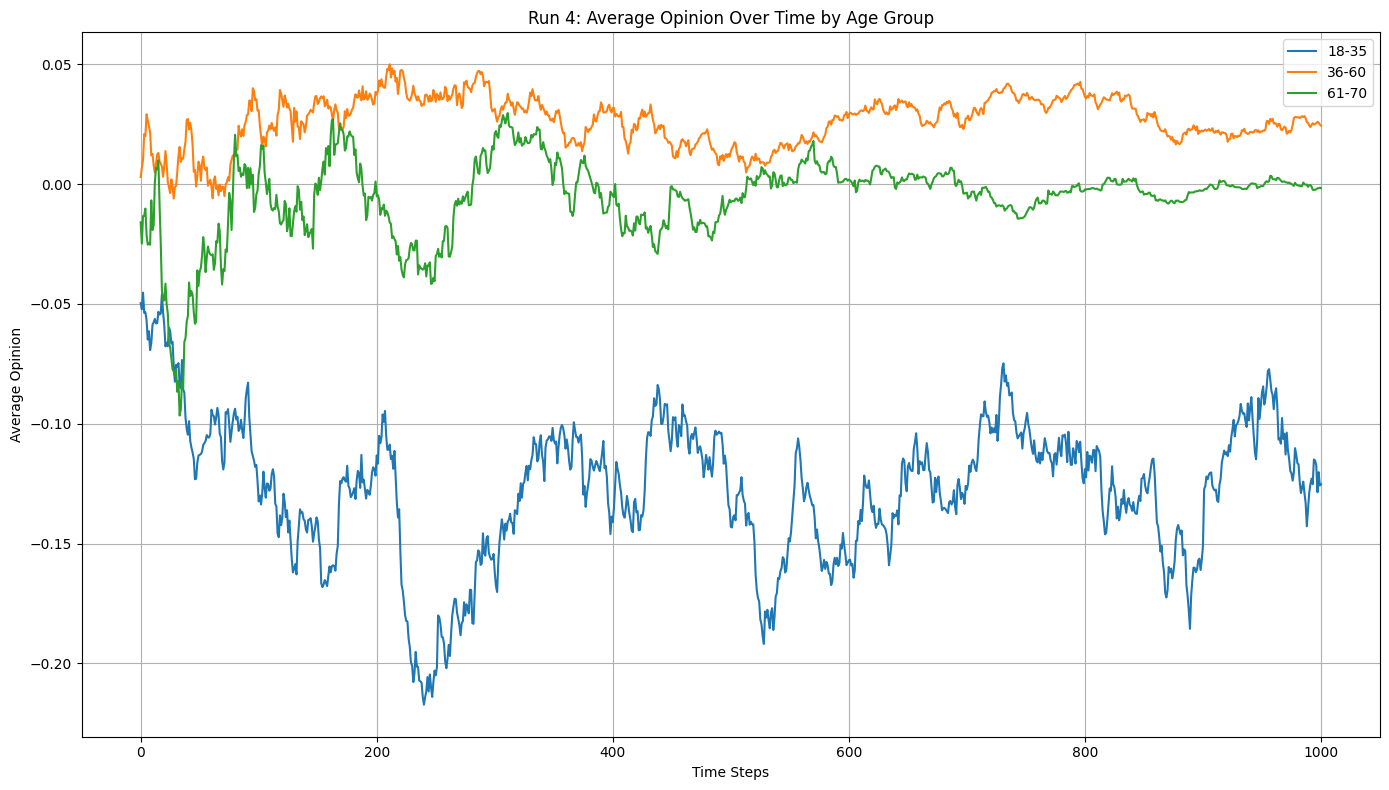

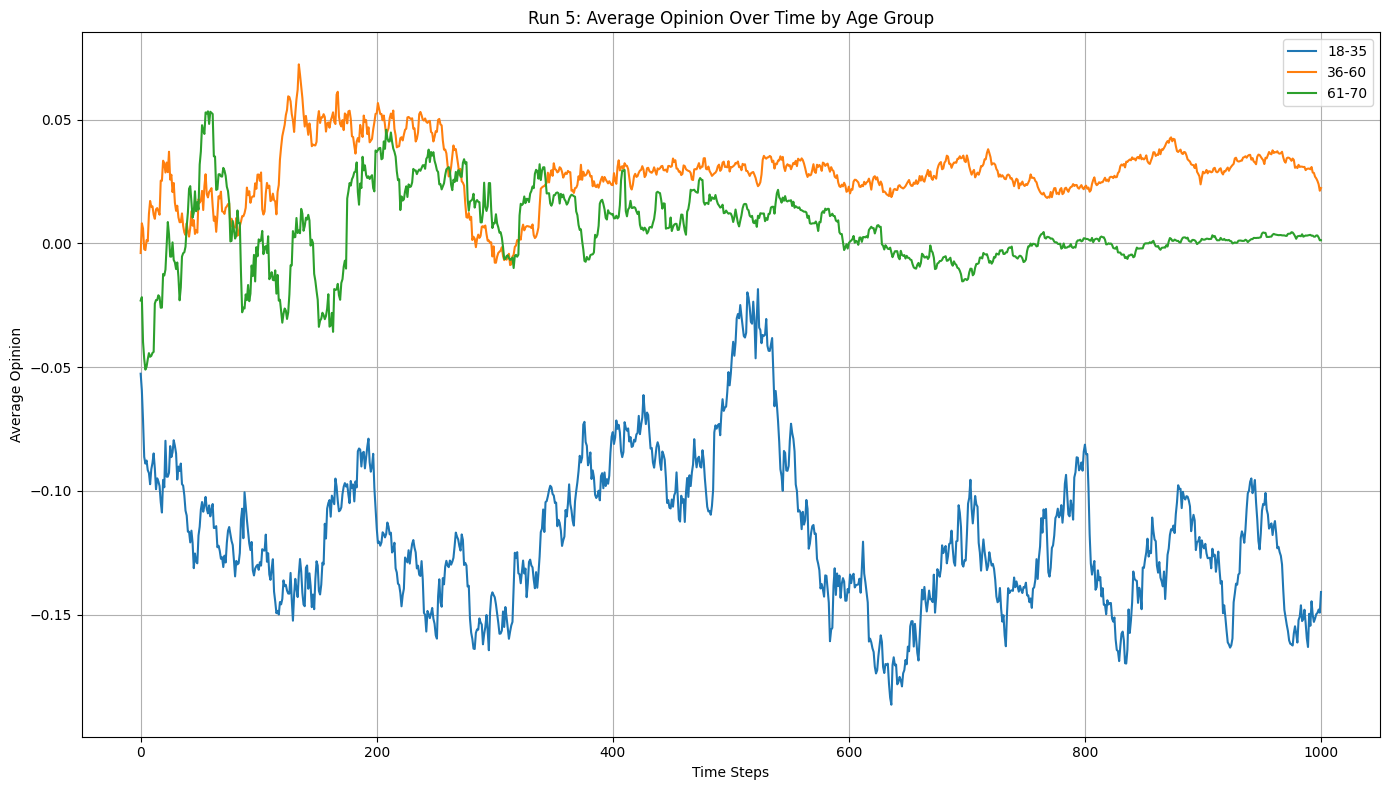

In [ ]:
N = 1000          # agents
L = 200           # arena size (200x200 grid)
d = 0.95          # diffusion probability
beta = 0.05       # opinion adoption probability
alpha = 0.01      # probability of spontaneous opinion change
sim_steps = 1000  # simulation steps
gamma = 0.1       # convergence rate
delta = 0.3      # media influence rate 

runs = 5  

# media sources
media_sources = [
    {
        'name': 'Social Media',
        'target_age_range': (18, 35),
        'media_opinion': -6.0, 
        'influence_probability': 0.01
    },
    {
        'name': 'Television',
        'target_age_range': (36, 60),
        'media_opinion': 0.2, 
        'influence_probability': 0.01 
    },
    {
        'name': 'Newspapers',
        'target_age_range': (61, 70),
        'media_opinion': 0.0, 
        'influence_probability': 0.01 
    }
]

# age groups for tracking
age_groups = {
    '18-35': None,  
    '36-60': None,
    '61-70': None
}

# tracking dictionary for all runs
all_average_opinions_age_groups = []

# Run the simulation multiple times
for run in range(1, runs + 1):
    print(f"\nRun {run} started.")
    
    # agent positions randomly on the grid
    x = np.random.randint(L, size=N)
    y = np.random.randint(L, size=N)
    

    # random initial opinion
    opinions = np.random.uniform(-1, 1, size=N)
    
    # assign ages to agents randomly between 18 and 70
    min_age = 18
    max_age = 70
    ages = np.random.randint(min_age, max_age + 1, size=N)
    
    # assign susceptibility based on age
    susceptibility = assign_susceptibility(ages)
    
    # assign age group labels
    age_group_labels = [assign_age_group(age) for age in ages]
    
    # define age groups by selecting agent indices
    age_groups['18-35'] = np.where((ages >= 18) & (ages <= 35))[0]
    age_groups['36-60'] = np.where((ages >= 36) & (ages <= 60))[0]
    age_groups['61-70'] = np.where((ages >= 61) & (ages <= 70))[0]
    
    # tracking for average opinions in each age group
    average_opinions_age_groups = {group: [] for group in age_groups}
    
    # record initial average opinions for each age group
    for group, indices in age_groups.items():
        if len(indices) > 0:
            average_opinions_age_groups[group].append(np.mean(opinions[indices]))
        else:
            average_opinions_age_groups[group].append(0)  # Handle empty groups
    
    # simulation loop
    for step in range(1, sim_steps + 1):
        x, y, opinions = diffuse_and_opinion_change_with_media(
            x, y, opinions, d, beta, alpha, L, susceptibility, ages, media_sources, age_group_labels
        )
        
        # update average opinions for each age group
        for group, indices in age_groups.items():
            if len(indices) > 0:
                avg_op = np.mean(opinions[indices])
                average_opinions_age_groups[group].append(avg_op)
            else:
                average_opinions_age_groups[group].append(0)  # Handle empty groups
        
        #  convergence criteria
        overall_avg_opinion = np.mean(opinions)
        if np.abs(overall_avg_opinion) == 1.0:
            print(f"Run {run} converged to consensus at step {step}.")
            # Extend the average_opinions list to match sim_steps if needed
            for group in age_groups:
                last_value = average_opinions_age_groups[group][-1]
                average_opinions_age_groups[group] += [last_value] * (sim_steps - step)
            break
    
    # append the tracking data for this run
    all_average_opinions_age_groups.append(average_opinions_age_groups)

for run_idx, run_data in enumerate(all_average_opinions_age_groups):
    plt.figure(figsize=(14, 8))
    for group, opinions_list in run_data.items():
        plt.plot(opinions_list, label=group)
    plt.title(f'Run {run_idx + 1}: Average Opinion Over Time by Age Group')
    plt.xlabel('Time Steps')
    plt.ylabel('Average Opinion')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()